In [1]:
import pickle
import numpy as np

import sys
sys.path.append('../../../')
import ndrought.drought_network_v12 as dnet
import ndrought.wrangle_v11 as dnw
import ndrought.plotting as nplot

import matplotlib as mpl
import matplotlib.pyplot as plt

import pandas as pd
import xarray as xr

from tqdm.autonotebook import tqdm

import geopandas as gpd

/pool0/data/steinjao/drought/drought_impact/notebooks/analysis/plotting/../../../ndrought/wrangle_v11.py:18: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
paired_ds = xr.open_dataset('/pool0/home/steinadi/data/drought/drought_impact/data/drought_measures/ndrought_products/CONUS_105W/paired_ds/usdm_spi_paired.nc')

In [39]:
paired_ds = paired_ds.rename({'index':'time'})

In [40]:
paired_ds

<xarray.Dataset>
Dimensions:    (time: 1149, y: 702, x: 525)
Coordinates:
  * time       (time) int64 0 1 2 3 4 5 6 ... 1142 1143 1144 1145 1146 1147 1148
  * y          (y) float64 3.251e+06 3.246e+06 3.242e+06 ... 2.717e+05 2.674e+05
  * x          (x) float64 -2.893e+06 -2.889e+06 ... -6.674e+05 -6.632e+05
Data variables:
    USDM       (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    USDM Date  (time) datetime64[ns] 2000-01-04 2000-01-11 ... 2022-01-04
    spi_14d    (time, y, x) float32 ...
    spi_30d    (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    spi_90d    (time, y, x) float32 ...
    spi_180d   (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    spi_270d   (time, y, x) float32 ...
    spi_1y     (time, y, x) float32 ...
    spi_2y     (time, y, x) float32 ...
    spi_5y     (time, y, x) float32 ...
    SPI Date   (time) datetime64[ns] 1999-12-31 2000-01-10 ... 2021-12-31

(array([66112191.,        0., 33193336.,        0., 29777753.,        0.,
        27008863.,        0., 16953803.,  5020793.]),
 array([-1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ]),
 <BarContainer object of 10 artists>)

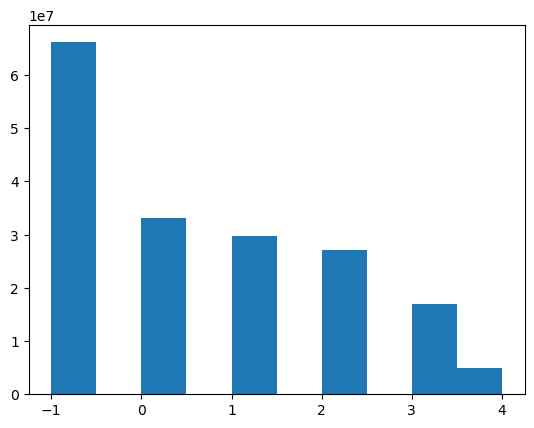

In [3]:
plt.hist(paired_ds['USDM'].values.ravel())

(array([11271153., 11110105., 16869088., 27201974., 30863945., 29115625.,
        23533891., 13598617.,  8754399.,  8557932.]),
 array([-2.09000015e+00, -1.67200017e+00, -1.25400019e+00, -8.36000204e-01,
        -4.18000221e-01, -2.38418579e-07,  4.17999744e-01,  8.35999727e-01,
         1.25399971e+00,  1.67199969e+00,  2.08999968e+00]),
 <BarContainer object of 10 artists>)

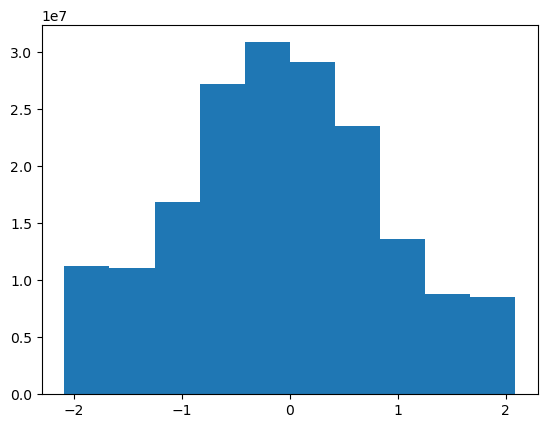

In [37]:
plt.hist(paired_ds['spi_30d'].values.ravel())

In [44]:
percentiles = [30, 20, 10, 5, 2]

In [45]:
spi30d = dnw.dm_to_usdmcat_multtime(paired_ds['spi_30d'], percentiles)

In [46]:
spi180d = dnw.dm_to_usdmcat_multtime(paired_ds['spi_180d'], percentiles)

In [43]:
((paired_ds.x.values[1] - paired_ds.x.values[0])/1e3)**2

18.111807648272816

In [4]:
area_constant = 18.1

In [5]:
df = gpd.read_file('/pool0/home/steinjao/data/drought/drought_impact/data/geometry/tl_2022_us_state.shp')
df.to_crs("EPSG:4326");
non_continental = ['HI','VI','MP','GU','AK','AS','PR']
us49 = df
for n in non_continental:
    us49 = us49[us49.STUSPS != n]

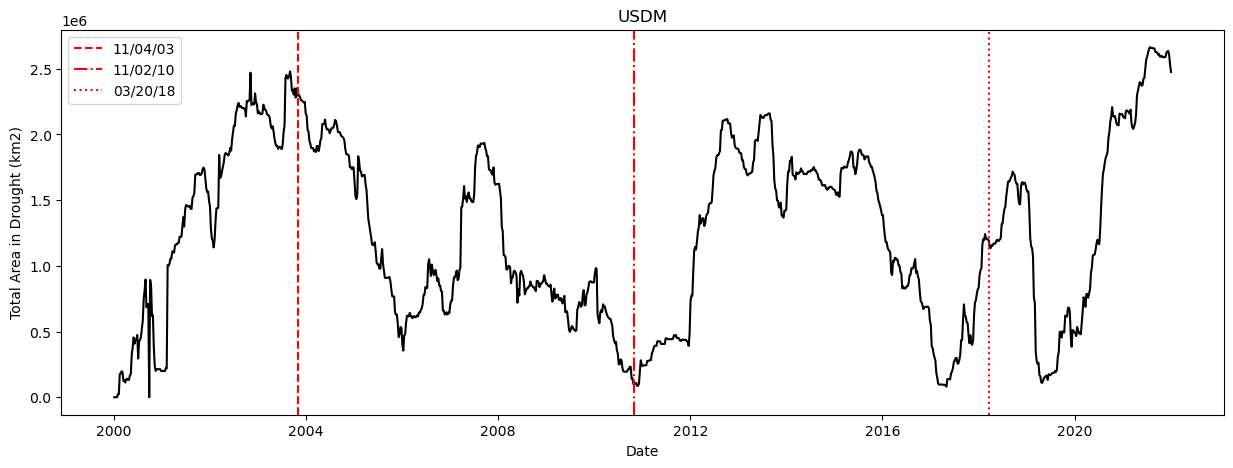

In [6]:
fig, ax = plt.subplots(figsize=(15,5))

ax.plot(paired_ds['USDM Date'].values, (paired_ds['USDM'].values >= 1).sum(axis=(1,2))*area_constant, color='k')
ax.set_ylabel('Total Area in Drought (km2)')
ax.set_xlabel('Date')
ax.set_title('USDM')
fig.set_facecolor('w')
ax.axvline(paired_ds['USDM Date'].values[200], color='r', linestyle='--', label=pd.to_datetime(paired_ds['USDM Date'].values[200]).strftime('%D'))
ax.axvline(paired_ds['USDM Date'].values[565], color='r', linestyle='-.', label=pd.to_datetime(paired_ds['USDM Date'].values[565]).strftime('%D'))
ax.axvline(paired_ds['USDM Date'].values[950], color='r', linestyle='dotted', label=pd.to_datetime(paired_ds['USDM Date'].values[950]).strftime('%D'))
ax.legend()

In [7]:
reproj_usdm = paired_ds['USDM'].rio.set_crs('EPSG:5070').rio.reproject('EPSG:4326')

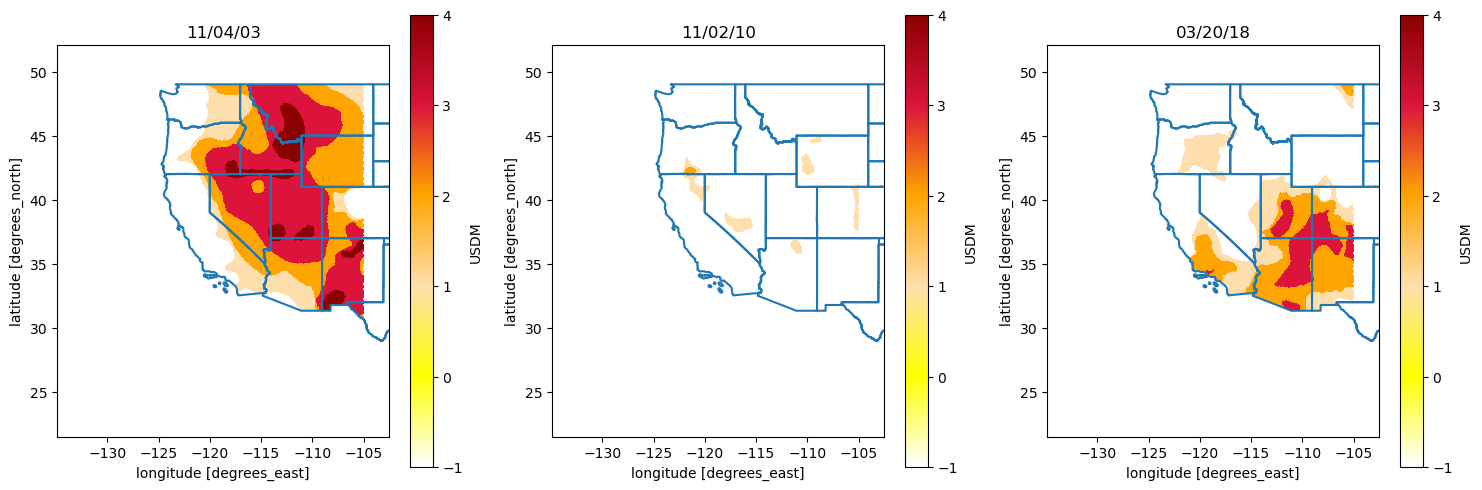

In [50]:
fig, axs = plt.subplots(1,3, figsize=(15,5))

for i, ax in zip([200, 565, 950], axs.ravel()):
    data = reproj_usdm.sel(index=i).values
    data[data == 0] = np.nan
    reproj_usdm_filtered = reproj_usdm.sel(index=i).copy()
    reproj_usdm_filtered.data = data
    reproj_usdm_filtered.plot(ax=ax, vmin=-1, vmax=4, cmap=nplot.usdm_cmap())
    us49.boundary.plot(ax=ax)
    ax.set_title(pd.to_datetime(paired_ds['USDM Date'].values[i]).strftime('%D'))
    #ax.set_ylabel('latitude (degrees_north)')
    #ax.set_xlabel('longitude (degrees_east)')
fig.set_facecolor('w')
plt.tight_layout()

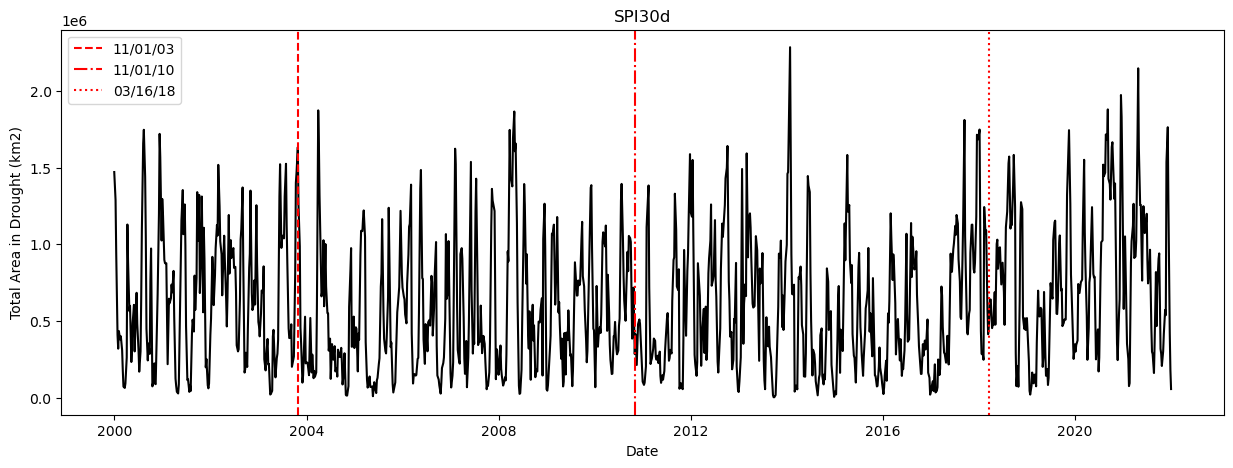

In [47]:
fig, ax = plt.subplots(figsize=(15,5))

ax.plot(paired_ds['SPI Date'].values, (spi30d.values >= 1).sum(axis=(1,2))*area_constant, color='k')
ax.set_ylabel('Total Area in Drought (km2)')
ax.set_xlabel('Date')
ax.set_title('SPI30d')
fig.set_facecolor('w')
ax.axvline(paired_ds['SPI Date'].values[200], color='r', linestyle='--', label=pd.to_datetime(paired_ds['SPI Date'].values[200]).strftime('%D'))
ax.axvline(paired_ds['SPI Date'].values[565], color='r', linestyle='-.', label=pd.to_datetime(paired_ds['SPI Date'].values[565]).strftime('%D'))
ax.axvline(paired_ds['SPI Date'].values[950], color='r', linestyle='dotted', label=pd.to_datetime(paired_ds['SPI Date'].values[950]).strftime('%D'))
ax.legend()

In [48]:
reproj_spi30d = spi30d.rio.set_crs('EPSG:5070').rio.reproject('EPSG:4326')

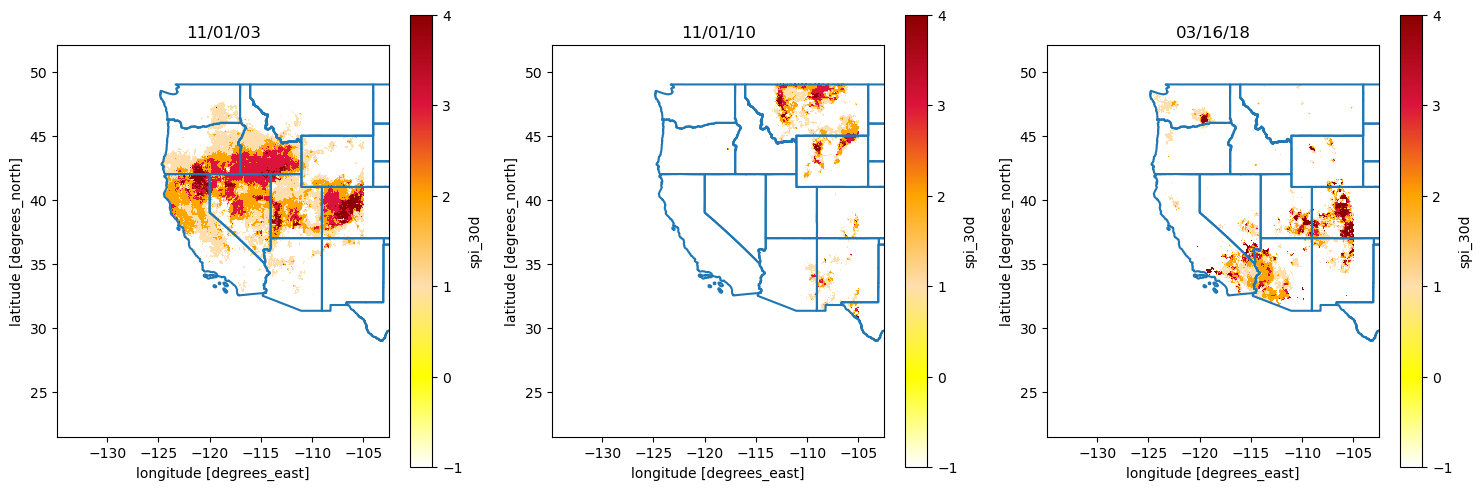

In [53]:
fig, axs = plt.subplots(1,3, figsize=(15,5))

for i, ax in zip([200, 565, 950], axs.ravel()):
    data = reproj_spi30d.sel(time=i).values
    data[data == 0] = np.nan
    reproj_spi30d_filtered = reproj_spi30d.sel(time=i).copy()
    reproj_spi30d_filtered.data = data
    reproj_spi30d_filtered.plot(ax=ax, vmin=-1, vmax=4, cmap=nplot.usdm_cmap())
    
    us49.boundary.plot(ax=ax)
    ax.set_title(pd.to_datetime(paired_ds['SPI Date'].values[i]).strftime('%D'))
fig.set_facecolor('w')
plt.tight_layout()

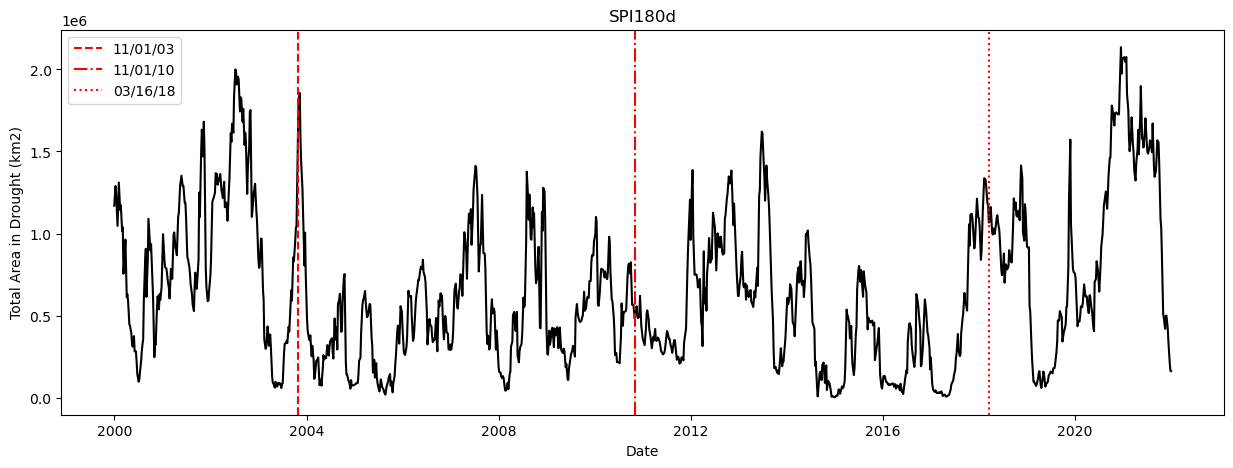

In [54]:
fig, ax = plt.subplots(figsize=(15,5))

ax.plot(paired_ds['SPI Date'].values, (spi180d.values >= 1).sum(axis=(1,2))*area_constant, color='k')
ax.set_ylabel('Total Area in Drought (km2)')
ax.set_xlabel('Date')
ax.set_title('SPI180d')
fig.set_facecolor('w')
ax.axvline(paired_ds['SPI Date'].values[200], color='r', linestyle='--', label=pd.to_datetime(paired_ds['SPI Date'].values[200]).strftime('%D'))
ax.axvline(paired_ds['SPI Date'].values[565], color='r', linestyle='-.', label=pd.to_datetime(paired_ds['SPI Date'].values[565]).strftime('%D'))
ax.axvline(paired_ds['SPI Date'].values[950], color='r', linestyle='dotted', label=pd.to_datetime(paired_ds['SPI Date'].values[950]).strftime('%D'))
ax.legend()

In [55]:
reproj_spi180d = spi180d.rio.set_crs('EPSG:5070').rio.reproject('EPSG:4326')

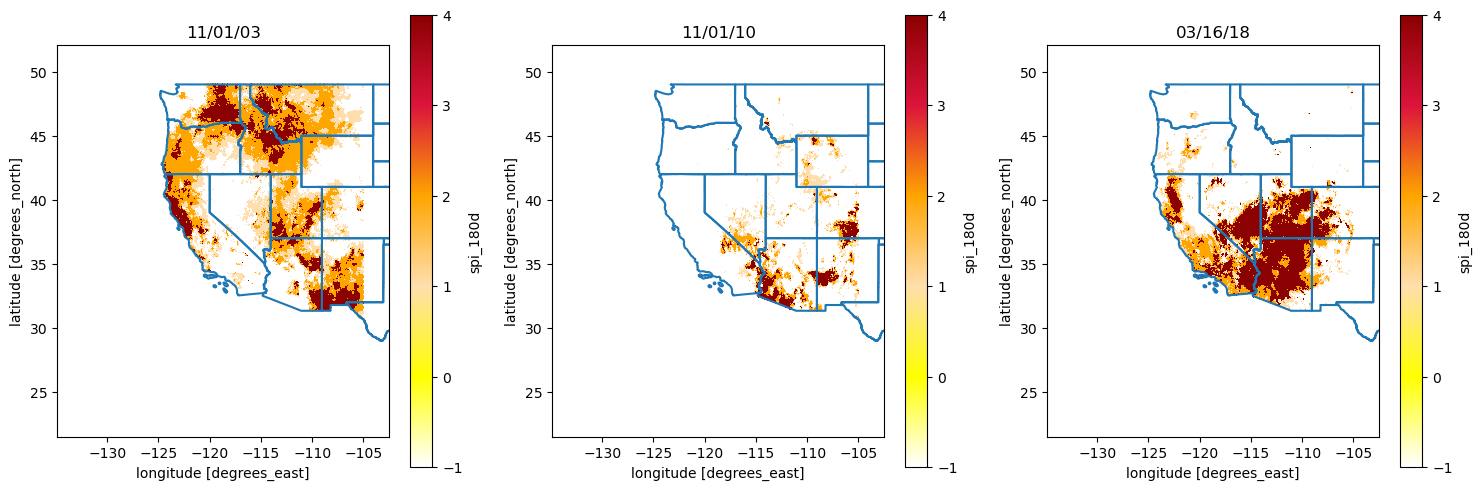

In [56]:
fig, axs = plt.subplots(1,3, figsize=(15,5))

for i, ax in zip([200, 565, 950], axs.ravel()):
    data = reproj_spi180d.sel(time=i).values
    data[data == 0] = -1
    reproj_spi180d_filtered = reproj_spi180d.sel(time=i).copy()
    reproj_spi180d_filtered.data = data
    reproj_spi180d_filtered.plot(ax=ax, vmin=-1, vmax=4, cmap=nplot.usdm_cmap())
    us49.boundary.plot(ax=ax)
    ax.set_title(pd.to_datetime(paired_ds['SPI Date'].values[i]).strftime('%D'))
fig.set_facecolor('w')
plt.tight_layout()